# Analyzing SLAC Run 1936 with `pandas`

The input will be the `eventTree` from the `SlacAnalyzer`

---

### Import the required libraries

In [1]:
import ROOT
import pandas as pd
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
# seaborn helps makes the plots a little prettier
import seaborn
# set inline plot size
plt.rcParams['figure.figsize'] = 10, 8

Welcome to JupyROOT 6.08/02


### Open the ROOT file and grab the `eventTree`

In [2]:
slacf = ROOT.TFile("gm2slac_run01936.root")
slact = slacf.Get('slacAnalyzer/eventTree')

# we are only going to use the CrystalHits
slact.SetBranchStatus("*",0)
for used_branch in ['EventNum', 'IslandNum', 'XtalNum', 'Energy', 'Time']:
    slact.SetBranchStatus('XtalHit_' + used_branch)

slact.GetEntries()

3002L

### Build a pandas dataframe out of CrystalHits
**To make things simple, we'll start with one row per CrystalHit. After this, we won't need ROOT anymore**

In [3]:
framevals = []
for entry in slact:
    framevals.extend(vals for vals in zip(
        entry.XtalHit_EventNum, entry.XtalHit_IslandNum, entry.XtalHit_XtalNum,
        entry.XtalHit_Energy, entry.XtalHit_Time))

xtal_df = pd.DataFrame(framevals, columns=['event num', 'island num', 'xtal num', 'energy', 'time'])
xtal_df.head()

,event num,island num,xtal num,energy,time
0,1,0,0,2303.802986,0.0
1,1,0,1,1805.522496,0.0
2,1,0,2,1171.798774,0.0
3,1,0,3,2146.997599,0.0
4,1,0,4,1447.375665,0.0


**What we really need is one island per row so we can do clustering and look at correlations between crystals. This can be accomplished by "pivoting" the dataframe. The step below will sum energies and average times that have the same event number and island number, but that's ok for our tests here because pileup is not a concern in a typical SLAC run.**

In [4]:
xtal_df = xtal_df.pivot_table(index=['event num', 'island num'], columns=['xtal num'], 
                              values=['energy','time'], aggfunc={'energy' : np.sum, 'time' : np.mean})
xtal_df.head()

energy                                         \
xtal num                       0            1            2            3    
event num island num                                                       
1         0           2303.802986  1805.522496  1171.798774  2146.997599   
          1                   NaN          NaN          NaN          NaN   
          2           2219.305607  1958.452230  1202.910393  2145.743336   
          3           2254.249445  1895.293027  1155.732341  2169.819746   
          4           2437.819589  1910.349603  1140.248909  2159.901436   

                                                                          \
xtal num                       4            5            6            7    
event num island num                                                       
1         0           1447.375665  1259.818874  1327.311119  1380.139813   
          1                   NaN          NaN     9.398807     8.375607   
          2           1513.941682  1235.970722  1281.651281  1392.025848   
          3           1465.957640  1269.222050  1339.891038  1356.862263   
          4           1544.416421  1309.497038  1310.658191  1385.669817   

                                                    ...                 time  \
xtal num                       8            9       ...                   44   
event num island num                                ...                        
1         0           1520.244239  1660.798957      ...             0.000000   
          1                   NaN          NaN      ...                  NaN   
          2           1484.167472  1701.375880      ...         73023.968263   
          3           1520.384274  1647.848590      ...        153032.367388   
          4           1487.878340  1772.208295      ...        233040.646450   

                                                                   \
xtal num                         45             46             47   
event num island num                                                
1         0                0.000000       0.000000       0.000000   
          1                     NaN            NaN            NaN   
          2            73023.922949   73023.917052   73023.925759   
          3           153032.384471  153032.361471  153032.362773   
          4           233040.651217  233040.644229  233040.672692   

                                                                   \
xtal num                         48             49             50   
event num island num                                                
1         0                0.000000       0.000000       0.000000   
          1                     NaN            NaN            NaN   
          2            73023.885146   73023.932592   73023.899892   
          3           153032.356790  153032.315116  153032.338986   
          4           233040.578283  233040.616225  233040.624337   

                                                                   
xtal num                         51             52             53  
event num island num                                               
1         0                0.000000       0.000000       0.000000  
          1                     NaN            NaN            NaN  
          2            73023.903413   73023.952338   73023.897621  
          3           153032.313632  153032.399068  153032.324861  
          4           233040.612103  233040.662367  233040.593739  

[5 rows x 108 columns]

In [5]:
# times are in there too
xtal_df.time.head()

xtal num                         0              1              2   \
event num island num                                                
1         0                0.000000       0.000000       0.000000   
          1                     NaN            NaN            NaN   
          2            73023.898187   73023.880597   73023.898279   
          3           153032.305458  153032.295728  153032.321920   
          4           233040.591645  233040.580364  233040.591974   

xtal num                         3              4              5   \
event num island num                                                
1         0                0.000000       0.000000       0.000000   
          1                     NaN            NaN            NaN   
          2            73023.916616   73023.937914   73023.873960   
          3           153032.355647  153032.347124  153032.335971   
          4           233040.609234  233040.654222  233040.598740   

xtal num                         6              7              8   \
event num island num                                                
1         0                0.000000       0.000000       0.000000   
          1             1583.370117    1582.881167            NaN   
          2            73023.891904   73023.908131   73023.926527   
          3           153032.346808  153032.347852  153032.340317   
          4           233040.611419  233040.632002  233040.605279   

xtal num                         9       ...                   44  \
event num island num                     ...                        
1         0                0.000000      ...             0.000000   
          1                     NaN      ...                  NaN   
          2            73023.937593      ...         73023.968263   
          3           153032.359164      ...        153032.367388   
          4           233040.607437      ...        233040.646450   

xtal num                         45             46             47  \
event num island num                                                
1         0                0.000000       0.000000       0.000000   
          1                     NaN            NaN            NaN   
          2            73023.922949   73023.917052   73023.925759   
          3           153032.384471  153032.361471  153032.362773   
          4           233040.651217  233040.644229  233040.672692   

xtal num                         48             49             50  \
event num island num                                                
1         0                0.000000       0.000000       0.000000   
          1                     NaN            NaN            NaN   
          2            73023.885146   73023.932592   73023.899892   
          3           153032.356790  153032.315116  153032.338986   
          4           233040.578283  233040.616225  233040.624337   

xtal num                         51             52             53  
event num island num                                               
1         0                0.000000       0.000000       0.000000  
          1                     NaN            NaN            NaN  
          2            73023.903413   73023.952338   73023.897621  
          3           153032.313632  153032.399068  153032.324861  
          4           233040.612103  233040.662367  233040.593739  

[5 rows x 54 columns]

**create columns for energy weighted time and energy sum (clustering)**

In [6]:
xtal_df[('time', 'e-weighted')] = (xtal_df.energy*xtal_df.time).sum('columns') / xtal_df.energy.sum('columns')
xtal_df[('energy', 'sum')] = xtal_df.energy.sum('columns') 
xtal_df[[('energy', 'sum'), ('time', 'e-weighted')]].head()

energy           time
xtal num                       sum     e-weighted
event num island num                             
1         0           79252.538193       0.000000
          1            4218.243759    1583.131294
          2           79406.258732   73023.914197
          3           79385.621806  153032.341419
          4           79888.517854  233040.621100

**Split laser events from beam events using energy cut**

In [7]:
beam_mask = xtal_df[('energy', 'sum')] < 50000
beam_df = xtal_df.loc[beam_mask]
beam_df.head()

energy                                              \
xtal num                  0   1   2         3   4          5          6   
event num island num                                                      
1         1             NaN NaN NaN       NaN NaN        NaN   9.398807   
2         1             NaN NaN NaN       NaN NaN  16.070783  17.911669   
3         0             NaN NaN NaN       NaN NaN        NaN  16.160013   
4         2             NaN NaN NaN  15.65555 NaN  29.579959        NaN   
5         2             NaN NaN NaN       NaN NaN   7.657702   8.537765   

                                           ...      time                  \
xtal num                     7   8   9     ...        46  47  48  49  50   
event num island num                       ...                             
1         1           8.375607 NaN NaN     ...       NaN NaN NaN NaN NaN   
2         1                NaN NaN NaN     ...       NaN NaN NaN NaN NaN   
3         0                NaN NaN NaN     ...       NaN NaN NaN NaN NaN   
4         2                NaN NaN NaN     ...       NaN NaN NaN NaN NaN   
5         2                NaN NaN NaN     ...       NaN NaN NaN NaN NaN   

                                                                      energy  
xtal num                       51           52  53   e-weighted          sum  
event num island num                                                          
1         1                   NaN          NaN NaN  1583.131294  4218.243759  
2         1                   NaN          NaN NaN  1575.615620  4577.144106  
3         0                   NaN          NaN NaN  1588.562032  2316.348595  
4         2           1590.898835          NaN NaN  1590.306811  4338.560037  
5         2                   NaN  1586.322431 NaN  1585.042534  4395.552272  

[5 rows x 110 columns]

In [8]:
laser_df = xtal_df.loc[~beam_mask]
laser_df.head()

energy                                         \
xtal num                        0            1            2            3   
event num island num                                                       
1         0           2303.802986  1805.522496  1171.798774  2146.997599   
          2           2219.305607  1958.452230  1202.910393  2145.743336   
          3           2254.249445  1895.293027  1155.732341  2169.819746   
          4           2437.819589  1910.349603  1140.248909  2159.901436   
          5           2181.160542  1878.970640  1156.019769  2071.477510   

                                                                          \
xtal num                        4            5            6            7   
event num island num                                                       
1         0           1447.375665  1259.818874  1327.311119  1380.139813   
          2           1513.941682  1235.970722  1281.651281  1392.025848   
          3           1465.957640  1269.222050  1339.891038  1356.862263   
          4           1544.416421  1309.497038  1310.658191  1385.669817   
          5           1552.623340  1244.312800  1356.592300  1365.413578   

                                                    ...                time  \
xtal num                        8            9      ...                  46   
event num island num                                ...                       
1         0           1520.244239  1660.798957      ...            0.000000   
          2           1484.167472  1701.375880      ...        73023.917052   
          3           1520.384274  1647.848590      ...       153032.361471   
          4           1487.878340  1772.208295      ...       233040.644229   
          5           1569.787589  1637.240114      ...       313048.819515   

                                                                   \
xtal num                         47             48             49   
event num island num                                                
1         0                0.000000       0.000000       0.000000   
          2            73023.925759   73023.885146   73023.932592   
          3           153032.362773  153032.356790  153032.315116   
          4           233040.672692  233040.578283  233040.616225   
          5           313048.799255  313048.776036  313048.759915   

                                                                   \
xtal num                         50             51             52   
event num island num                                                
1         0                0.000000       0.000000       0.000000   
          2            73023.899892   73023.903413   73023.952338   
          3           153032.338986  153032.313632  153032.399068   
          4           233040.624337  233040.612103  233040.662367   
          5           313048.762519  313048.741535  313048.766288   

                                                          energy  
xtal num                         53     e-weighted           sum  
event num island num                                              
1         0                0.000000       0.000000  79252.538193  
          2            73023.897621   73023.914197  79406.258732  
          3           153032.324861  153032.341419  79385.621806  
          4           233040.593739  233040.621100  79888.517854  
          5           313048.742859  313048.763069  79454.304166  

[5 rows x 110 columns]

***We'll also want a frame with only the single electron beam events.***

In [9]:
single_mask = (beam_df[('energy', 'sum')] < 3500) & (beam_df[('energy', 'sum')] > 1000)
single_df = beam_df.loc[single_mask]
single_df.head()                                                             

energy                                                    \
xtal num                  0   1   2   3   4   5          6   7          8   9   
event num island num                                                            
3         0             NaN NaN NaN NaN NaN NaN  16.160013 NaN        NaN NaN   
12        0             NaN NaN NaN NaN NaN NaN  13.744248 NaN        NaN NaN   
19        0             NaN NaN NaN NaN NaN NaN        NaN NaN        NaN NaN   
21        1             NaN NaN NaN NaN NaN NaN        NaN NaN        NaN NaN   
22        0             NaN NaN NaN NaN NaN NaN        NaN NaN  13.350615 NaN   

                         ...      time                                       \
xtal num                 ...        46  47  48  49  50  51           52  53   
event num island num     ...                                                  
3         0              ...       NaN NaN NaN NaN NaN NaN          NaN NaN   
12        0              ...       NaN NaN NaN NaN NaN NaN          NaN NaN   
19        0              ...       NaN NaN NaN NaN NaN NaN          NaN NaN   
21        1              ...       NaN NaN NaN NaN NaN NaN  1580.092581 NaN   
22        0              ...       NaN NaN NaN NaN NaN NaN          NaN NaN   

                                        energy  
xtal num               e-weighted          sum  
event num island num                            
3         0           1588.562032  2316.348595  
12        0           1570.274917  2239.947428  
19        0           1572.759033  2203.313395  
21        1           1578.854784  2206.526851  
22        0           1574.890154  2299.547280  

[5 rows x 110 columns]

## Data structures are all in place, time to make some plots!

### Start with some energy plots

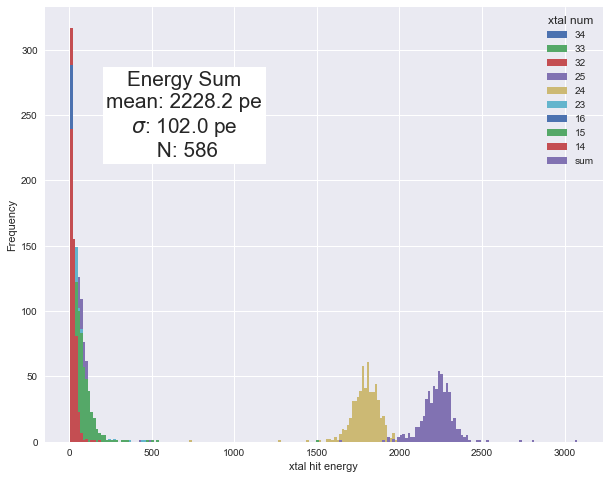

In [10]:
# plot xtal energies and their sum
center_num = 24
x_nums = [center_num + 10 - 9*(i/3) - i%3 for i in range(9)]
a = single_df.energy.loc[:,x_nums + ['sum']].plot.hist(bins=200)
stats = single_df.energy.describe()['sum']
plt.text(.25, .75, 'Energy Sum\nmean: {0:.1f} pe\n$\sigma$: {1:.1f} pe\n N: {2:.0f}'.
         format(stats['mean'], stats['std'], stats['count']), 
         horizontalalignment='center', verticalalignment='center', 
         transform=a.transAxes, size='xx-large', bbox=dict(facecolor='white', edgecolor='none'))
plt.xlabel('xtal hit energy')

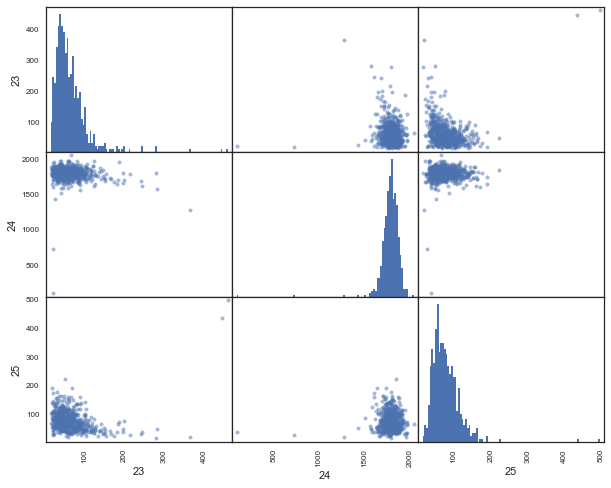

In [11]:
# crystal energy scatter matrix
seaborn.set_style('white')
from pandas.tools.plotting import scatter_matrix
smatrices=scatter_matrix(single_df.energy.iloc[:,23:26], hist_kwds={'bins': 100})

(0, 2500)

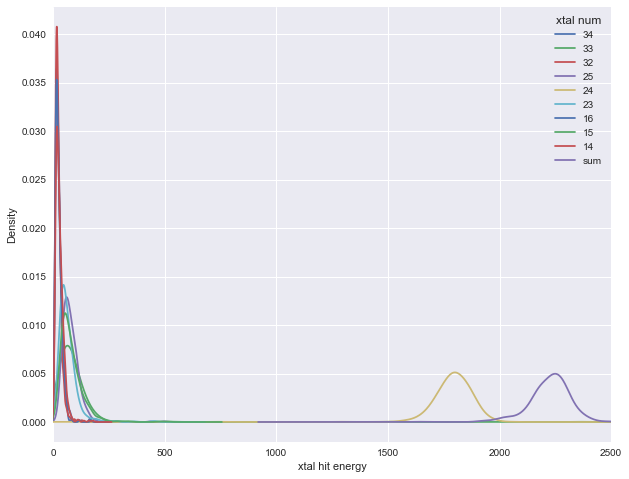

In [12]:
seaborn.set_style('darkgrid')
a = single_df.energy.loc[:,x_nums + ['sum']].plot.kde()
plt.xlabel('xtal hit energy')
plt.xlim(0,2500)

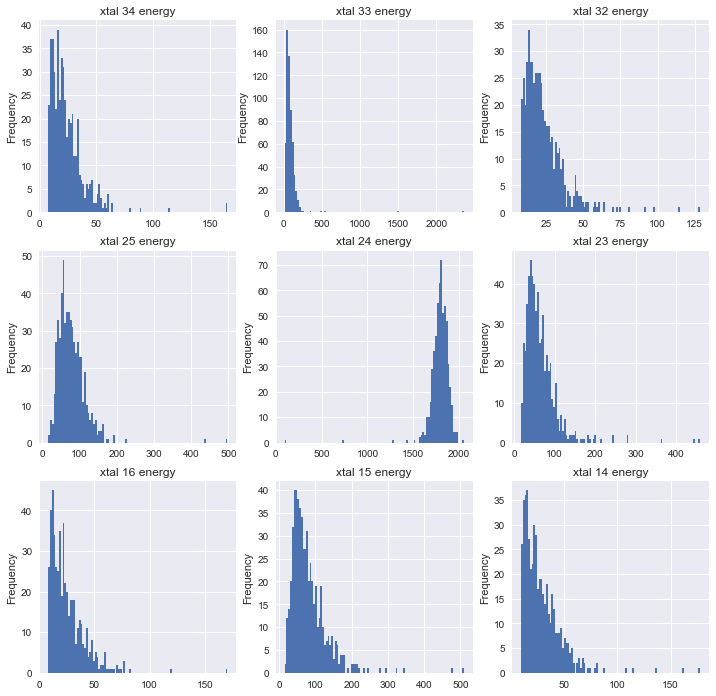

In [13]:
plt.rcParams['figure.figsize'] = 12, 12
for plotnum in range(0,9):
    plt.subplot(3,3,plotnum+1)
    x_num = x_nums[plotnum]
    (single_df.energy[x_num]).plot.hist(bins=100)
    plt.title('xtal {} energy'.format(x_num))

## And some timing plots

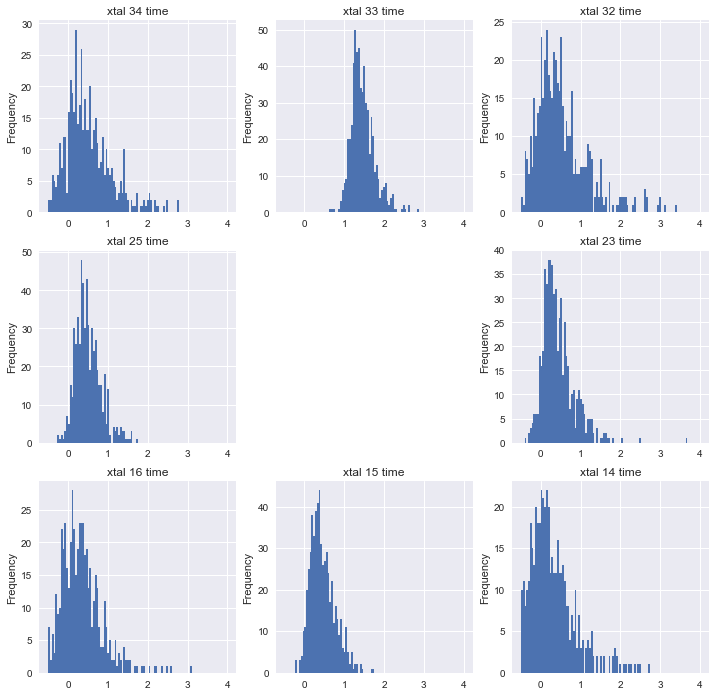

In [14]:
plt.rcParams['figure.figsize'] = 12, 12
for plotnum in range(0,9):
    if plotnum == 4:
        continue
    plt.subplot(3,3,plotnum+1)
    x_num = x_nums[plotnum]
    (single_df.time[x_num] - single_df.time[24]).plot.hist(bins=100, range=(-0.5,4))
    plt.title('xtal {} time'.format(x_num))

## For fun, lets try to implement the position reconstruction algorithm as well

In [15]:
# create a data frame with a convenient structure for doing the pos recon
hit_stack = single_df.energy[range(54)].stack() 
hit_stack = hit_stack.reset_index(level='xtal num')

hit_stack.columns = ['xtal num', 'energy']
hit_stack['island sum'] = hit_stack.energy.groupby(level=('event num', 'island num')).transform(np.sum)
hit_stack['x'] = 8.5 - hit_stack['xtal num'] % 9
hit_stack['y'] = hit_stack['xtal num'] // 9 + 0.5

hit_stack.head()

xtal num      energy   island sum    x    y
event num island num                                             
3         0                  6   16.160013  2316.348595  2.5  0.5
          0                 14   47.758407  2316.348595  3.5  1.5
          0                 15  137.575468  2316.348595  2.5  1.5
          0                 16   60.039854  2316.348595  1.5  1.5
          0                 23   42.984917  2316.348595  3.5  2.5

In [16]:
# calculate weight
w0 = 4.0
hit_stack['weight'] = np.maximum(0,w0 + np.log(hit_stack.energy / hit_stack['island sum']))
hit_stack.head()

xtal num      energy   island sum    x    y    weight
event num island num                                                       
3         0                  6   16.160013  2316.348595  2.5  0.5  0.000000
          0                 14   47.758407  2316.348595  3.5  1.5  0.118408
          0                 15  137.575468  2316.348595  2.5  1.5  1.176425
          0                 16   60.039854  2316.348595  1.5  1.5  0.347261
          0                 23   42.984917  2316.348595  3.5  2.5  0.013102

In [17]:
# calculate positions!
# add weight sum column
grouped = hit_stack.groupby(level=('event num', 'island num'), group_keys=False)
hit_stack['wsum'] = grouped.weight.transform(np.sum) 

xs = grouped.apply(lambda x: (x.weight*x.x).sum()/x.wsum.iloc[0])
ys = grouped.apply(lambda x: (x.weight*x.y).sum()/x.wsum.iloc[0])

# also use the bad "center of energy" technique to compare
xcoe = grouped.apply(lambda x: (x.energy*x.x).sum()/x['island sum'].iloc[0])
ycoe = grouped.apply(lambda x:(x.energy*x.y).sum()/x['island sum'].iloc[0])
pos_frame = pd.DataFrame({'x' : xs, 'y': ys, 'xcoe': xcoe, 'ycoe': ycoe})
pos_frame.head()

,,x,xcoe,y,ycoe
event num,island num,,,,
3,0,2.336039,2.468678,2.267374,2.415278
12,0,2.453213,2.466784,2.418744,2.453229
19,0,2.245603,2.465207,2.488026,2.483971
21,1,2.393935,2.438622,2.706940,2.586631
22,0,2.390422,2.481971,2.569767,2.534804


## Make some position reconstruction plots

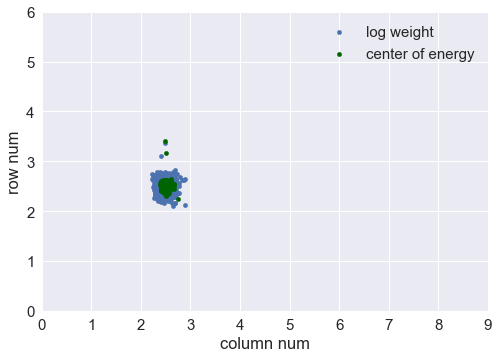

In [18]:
plt.rcParams['figure.figsize'] = 9, 6
seaborn.set(font_scale=1.5)
# plot the calculated positions and center of energy positions
ax = pos_frame.plot(kind='scatter', x='x', y='y', label='log weight')
pos_frame.plot(kind='scatter', x='xcoe', y='ycoe', label='center of energy', color='DarkGreen', ax=ax)
plt.xlim(0,9)
plt.ylim(0,6)
plt.xlabel('column num')
plt.ylabel('row num')

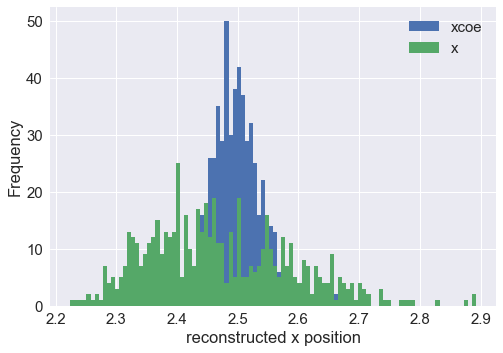

In [19]:
pos_frame[['xcoe','x']].plot.hist(bins=100)
plt.xlabel('reconstructed x position')

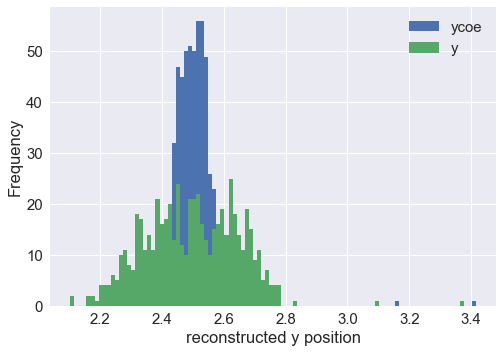

In [20]:
pos_frame[['ycoe','y']].plot.hist(bins=100)
plt.xlabel('reconstructed y position')

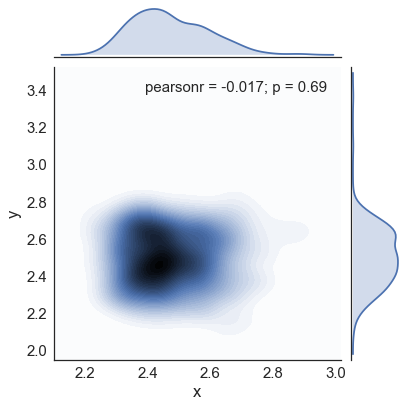

In [21]:
seaborn.set_style('white')
seaborn.jointplot(x='x', y='y', kind='kde', data=pos_frame, 
                  joint_kws={'n_levels': 40})

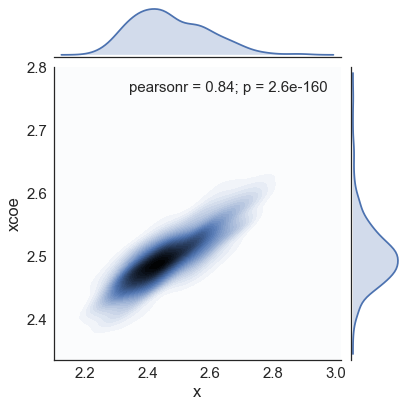

In [22]:
seaborn.set_style('white')
seaborn.jointplot(x='x', y='xcoe', kind='kde', data=pos_frame, joint_kws={'n_levels':40})

## Let's take a quick look at the laser energies

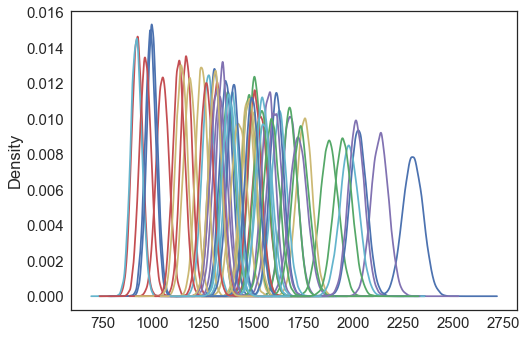

In [23]:
laser_df.energy.iloc[:,:54].plot.kde(legend=False)

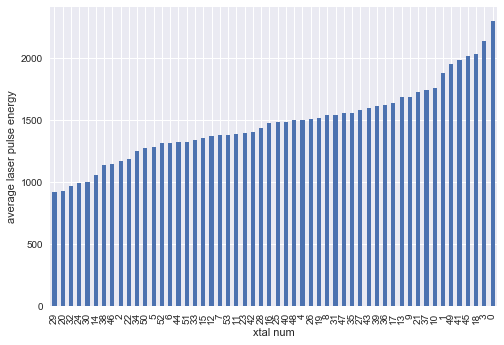

In [24]:
seaborn.set(font_scale=1)
laser_df.energy.iloc[:,:54].mean().sort_values().plot(kind='bar')
plt.ylabel('average laser pulse energy')